# 匀速运动退化图像的复原

## 匀速运动参数的估计

常用的图像复原方法有逆滤波、维纳滤波、约束最小二乘方滤波、几何均值滤波，应用这些滤波法之前都需要先知道运动模糊的传递函数 $H(u, v)$，因此对运动参数的估计是滤波前必须完成的工作。在构造匀速运动退化滤波器时，我们引入的参数包括曝光时间 $T$、沿 $x$ 方向的移动量 $a$，沿 $y$ 方向的移动量 $b$。通常在拿到一幅照片时曝光时间是已知的，而移动量则是未知的，因此我们需要设法从图片中估计参数 $a, b$。

### 运动方向的估计

我们首先对一幅经理想退化滤波的图像和一幅加入了高斯噪声的退化图像，计算其频谱，观察运动模糊在频谱上的特征。

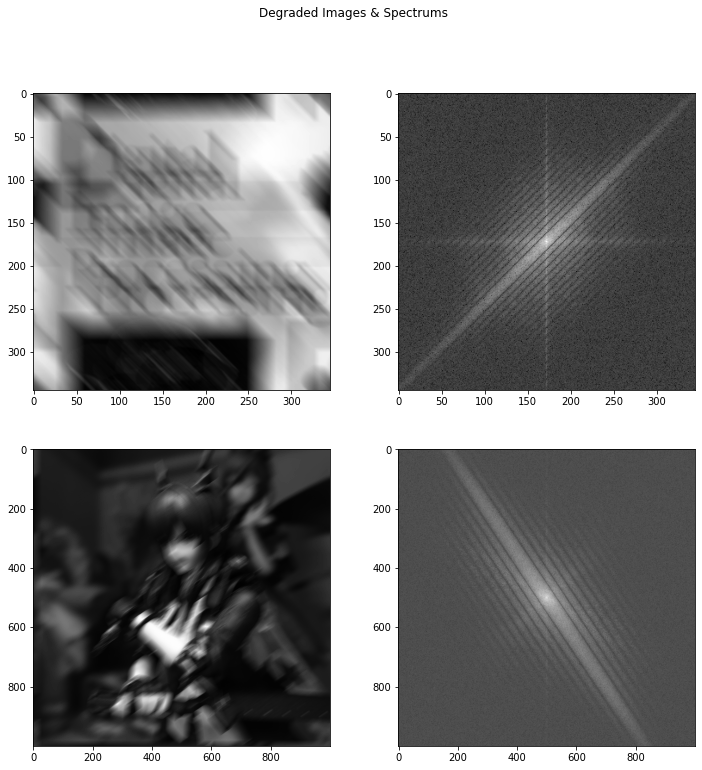

In [1]:
# 计算理想、实拍运动模糊图像的频谱
# 为了让频谱值更好被识别，显示之前对频谱取了对数
import matplotlib.pyplot as plt
import numpy as np

book_cover_filt = np.uint8(np.multiply(plt.imread('book_cover_filt.png'), 255))
book_cover_filt_fft = np.fft.fftshift(np.fft.fft2(book_cover_filt))

chen_figure_filt = np.uint8(np.multiply(plt.imread('chen_figure4_filt.png'), 255))
chen_figure_filt_fft = np.fft.fftshift(np.fft.fft2(chen_figure_filt))

fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle('Degraded Images & Spectrums')
ax11.imshow(book_cover_filt, cmap='gray')
ax12.imshow(np.log(1 + np.abs(book_cover_filt_fft)), cmap='gray')
ax21.imshow(chen_figure_filt, cmap='gray')
ax22.imshow(np.log(1 + np.abs(chen_figure_filt_fft)), cmap='gray')

我们容易在频谱中发现，具有运动模糊特征的图像的频谱中，除集中包含图像本身信息的十字亮线外，还有一条较亮的斜线。这条斜线是由于运动模糊产生的，与退化滤波器的频谱图像相对应，故可以从斜线中采集到关于运动参数的信息。

仍然使用基本原理的建模方法，我们从退化传递函数下手，观察频谱与函数中参数的关系。

$$ H(u, v) = \frac{T}{\pi (ua+vb)} \sin[\pi (ua+vb)] \mathrm{e}^{-\mathrm{j}\pi (ua+vb)} $$

由于我们对频谱取了模，上式可以写为模的形式

$$ |H(u, v)| = \left| \frac{T}{\pi (ua+vb)} \sin[\pi (ua+vb)] \right| $$

我们取 $T = 1$，并将 $ua+vb$ 换成 $x$，绘制出 $|H(u, v)|$ 与 $x$ 关系的图像。

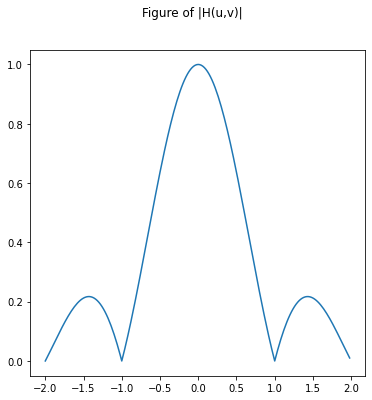

In [2]:
# 绘制|H(u,v)|的图像
T = 1

def evaluate_H_mod(x: float) -> float:
    if x == 0:
        return T
    return abs(T / (np.pi * x) * np.sin(np.pi * x))

x = [0 for i in range(200)]
H = [0 for i in range(200)]
x_step = 4 / 200
for i in range(200):
    x[i] = -2 + x_step * i
    H[i] = evaluate_H_mod(x[i])

fig, ax = plt.subplots(1, figsize=(6, 6))
fig.suptitle('Figure of |H(u,v)|')
ax.plot(x, H)

容易发现，这一函数在 $x=ua+vb=0$ 处取得最大值 $T$。因此，频谱中的斜线对应的就是 $ua+vb=0$ 直线，其斜率 $k=-\dfrac{b}{a}$ 可代表运动的方向。

### 运动距离的估计

通过观察，我们还可以发现，如果将图片沿运动方向平移，取图片的行相邻像素一阶差分（$f(x, y)-f(x-1, y)$），在恰好平移运动距离长度后一阶差分会出现自相关极小峰值。这是因为，在平移长度不超过运动距离时，图像中仍然有一部分因运动模糊产生的拖影重合；而长度等于运动距离时，重合恰好消失。我们可以利用这一原理估计运动的距离。

为了让实现更简单，我们先将图片旋转至运动方向与横坐标平行，再求一阶差分。以上面的图例进行测试，`book_cover_filt.jpg` 一图运动方向为 -45°，而 `chen_figma3.jpg` 一图约为 56°。

In [3]:
# 旋转图片至运动方向与横坐标方向平行，并求一阶差分
from typing import List
import scipy.ndimage as ndi

def rotate_and_diff(img: List[List], angle: float):
    img = ndi.rotate(img, angle)
    (n, m) = (len(img), len(img[0]))
    new_img = [[0 for _ in range(m)] for _ in range(n)]
    for i in range(n - 1, 0, -1):
        for j in range(m - 1, 0, -1):
            if i == 0:
                new_img[i][j] = int(img[i][j])
            else:
                new_img[i][j] = int(img[i][j]) - int(img[i - 1][j])
    return (img, new_img)

book_cover_r, book_cover_diff = rotate_and_diff(book_cover_filt.copy(), 45)
chen_figure_r, chen_figure_diff = rotate_and_diff(chen_figure_filt.copy(), -56)

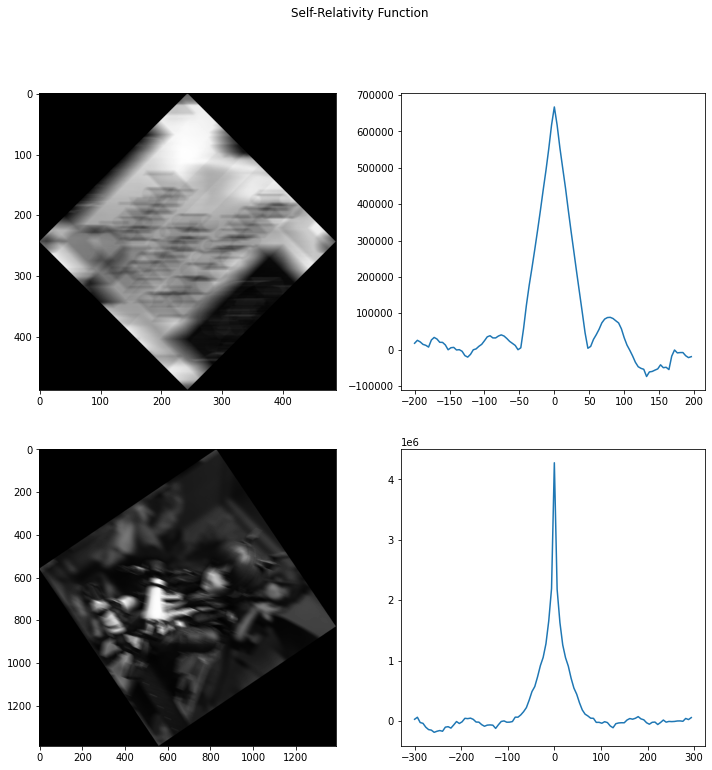

In [4]:
# 求出两幅图片的相关性函数
def get_relativity(img: List[List], shift: int) -> float:
    n, m = (len(img), len(img[0]))
    result = 0
    for i in range(n // 2 - n // 7, n // 2 + n // 7):
        for j in range(m // 2 - m // 7, m // 2 + m // 7):
            nj = ((j + shift) % m + m) % m
            result += int(img[i][j]) * int(img[i][nj])
    return result

n_sample = 100

x1 = [0 for _ in range(n_sample)]
R1 = [0 for _ in range(n_sample)]

x2 = [0 for _ in range(n_sample)]
R2 = [0 for _ in range(n_sample)]

for i in range(n_sample):
    x1[i] = -n_sample * 2 + i * 4
    R1[i] = get_relativity(book_cover_diff, x1[i])

    x2[i] = -n_sample * 3 + i * 6
    R2[i] = get_relativity(chen_figure_diff, x2[i])

fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle('Self-Relativity Function')

ax11.imshow(book_cover_r, cmap='gray')
ax12.plot(x1, R1)
ax21.imshow(chen_figure_r, cmap='gray')
ax22.plot(x2, R2)

上图中我们可以观察到，理想退化图像的极小值在 50 附近，但引入噪声的图像难以观察其极小值，需要其他方法帮助估计运动距离。在下面的实验中，我们将使用一组预计算的估计值处理引入造成的测试图片。

## 匀速运动退化图像的复原

### 逆滤波法

我们在之前已经得到了运动模糊图像的退化滤波器传递函数，因此只需要在频域除掉这个滤波器，即可实现对滤波效果的恢复。

In [5]:
# 逆滤波实现
from cmath import pi, sin, exp
from math import sqrt

def evaluate_H(T, a, b, u, v):
    if u * a + v * b == 0:
        return T
    return T / (pi * (u * a + v * b)) * sin(pi * (u * a + v * b)) * exp(-1j * pi * (u * a + v * b))

def inverse_filter(img, a, b, T, r):
    (n, m) = (len(img), len(img[0]))
    img_fft = np.fft.fftshift(np.fft.fft2(img))
    new_img_fft = img_fft.copy()
    for i in range(n // 2 - r, n // 2 + r):
        for j in range(m // 2 - r, m // 2 + r):
            if sqrt((i - n // 2)**2 + (j - m // 2)**2) > r:
                continue
            new_img_fft[i][j] /= evaluate_H(T, a, b, i - n // 2, j - m // 2)
    new_img = np.abs(np.fft.ifft2(np.fft.ifftshift(new_img_fft)))
    return img_fft, new_img_fft, new_img

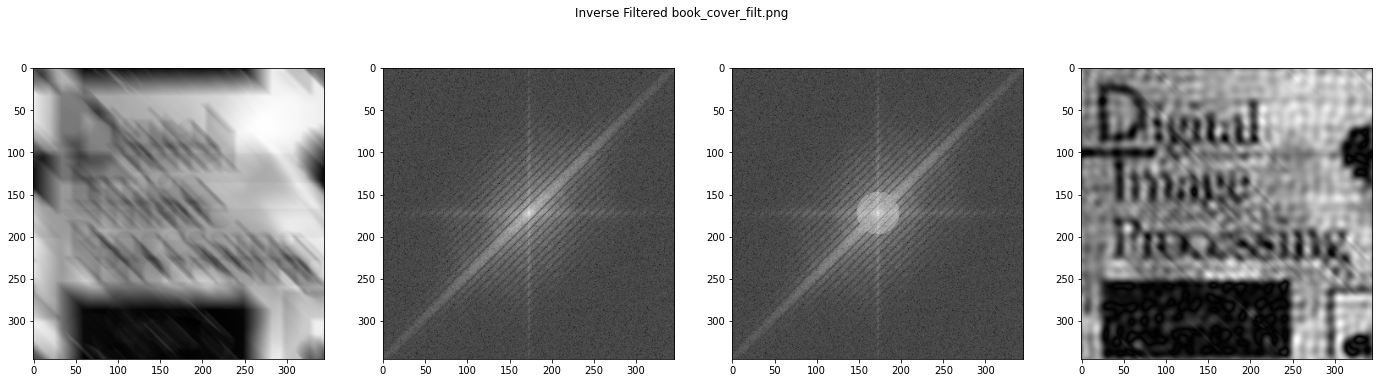

In [6]:
# book_cover_filt.png
(n, m) = (len(book_cover_filt), len(book_cover_filt[0]))
shift = 50
(x_shift, y_shift) = (shift * np.cos(-np.pi / 4), -shift * np.sin(-np.pi / 4))
book_fft, book_fft_new, book_new = inverse_filter(book_cover_filt, x_shift / n, y_shift / m, 1, 25)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
fig.suptitle('Inverse Filtered book_cover_filt.png')
ax1.imshow(book_cover_filt, cmap='gray')
ax2.imshow(np.log(np.abs(book_fft)), cmap='gray')
ax3.imshow(np.log(np.abs(book_fft_new)), cmap='gray')
ax4.imshow(book_new, cmap='gray')

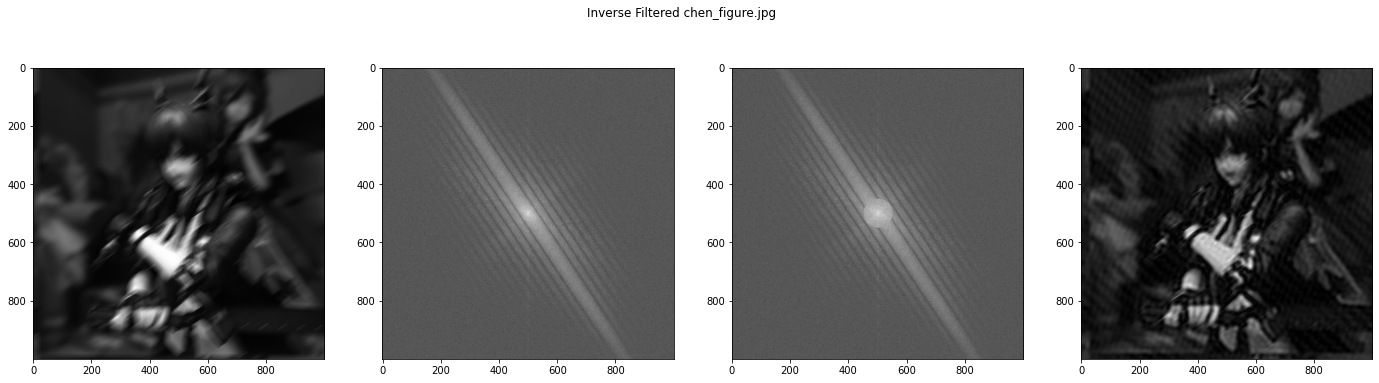

In [7]:
# chen_figure.jpg
(n, m) = (len(chen_figure_filt), len(chen_figure_filt[0]))
shift = 36
(x_shift, y_shift) = (shift * np.cos(np.pi / 180 * 56), -shift * np.sin(np.pi / 180 * 56))
chen_fft, chen_fft_new, chen_new = inverse_filter(chen_figure_filt, x_shift / n, y_shift / m, 1, 50)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
fig.suptitle('Inverse Filtered chen_figure.jpg')
ax1.imshow(chen_figure_filt, cmap='gray')
ax2.imshow(np.log(np.abs(chen_fft)), cmap='gray')
ax3.imshow(np.log(np.abs(chen_fft_new)), cmap='gray')
ax4.imshow(chen_new, cmap='gray')

由于图像中包含噪声等其他因素，逆滤波的过程中会使一部分噪声分量增加，导致复原结果被噪声分量支配，效果变差。我们采取了半径受限的方法，使滤波器的影响范围集中在低频附近的一个圆形区域，这有助于减少噪声分量对最终结果的影响。尽管如此，图片的恢复结果中仍能观察到噪声引起的一些斑点。

### 最小均方误差（维纳）滤波

当我们考虑噪声污染时，直接逆滤波得到的结果不佳，这时我们将得到原始图像的一个估计 $\hat{f}$。而维纳滤波的基础则是设法使估计与原始图像的均方误差最小，即 $e^2 = E\left\{\left(f-\hat{f}\right)^2\right\}$ 最小。

假设噪声和图像不相关，其中一个均值为 0，且估计中的灰度级是退化图像中灰度级的线性函数。在这些假设下，我们得到了误差函数的最小值在频域的表达式，即维纳滤波的表达式

$$ \hat{F}(u, v) = \left[ \frac{1}{H(u, v)} \frac{|H(u, v)|^2}{|H(u, v)|^2 + S_\eta(u, v) / S_f(u, v)} \right] G(u, v) $$

由于噪声谱和原始图像谱难以获知，我们通常使用简化的近似式

$$ \hat{F}(u, v) = \left[ \frac{1}{H(u, v)} \frac{|H(u, v)|^2}{|H(u, v)|^2 + K} \right] G(u, v) $$

其中 $K$ 是一个常数，合理地选择 $K$ 的值有助于提升滤波效果。

In [8]:
# 维纳滤波实现
def wiener_filter(img, K, a, b, T):
    (n, m) = (len(img), len(img[0]))
    img_fft = np.fft.fftshift(np.fft.fft2(img))
    new_img_fft = img_fft.copy()
    for i in range(n):
        for j in range(m):
            h_val = evaluate_H(T, a, b, i - n // 2, j - m // 2)
            new_img_fft[i][j] *= 1 / h_val * np.abs(h_val)**2 / (np.abs(h_val)**2 + K)
    new_img = np.abs(np.fft.ifft2(np.fft.ifftshift(new_img_fft)))
    return img_fft, new_img_fft, new_img

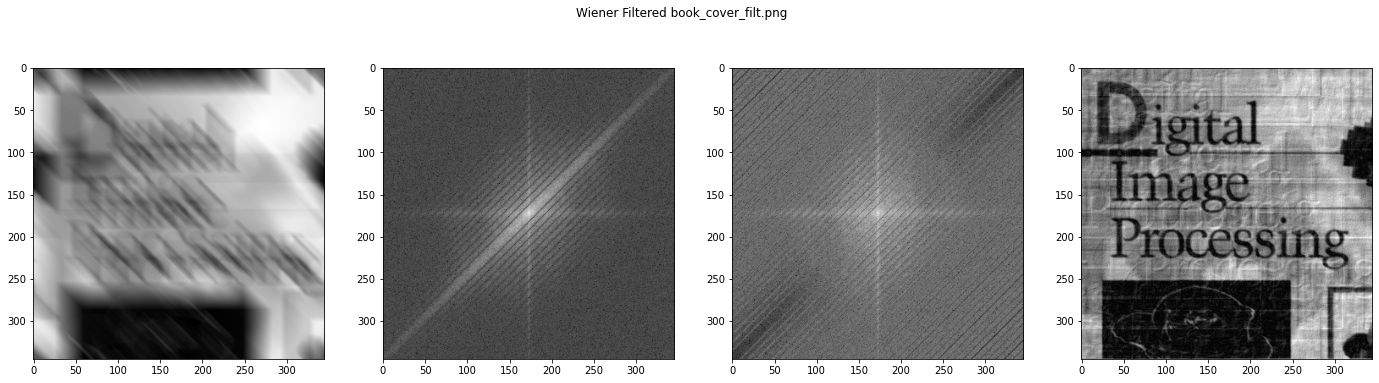

In [9]:
# book_cover_filt.png
(n, m) = (len(book_cover_filt), len(book_cover_filt[0]))
shift = 50
(x_shift, y_shift) = (shift * np.cos(-np.pi / 4), -shift * np.sin(-np.pi / 4))
book_fft, book_fft_new, book_new = wiener_filter(book_cover_filt, 1e-04, x_shift / n, y_shift / m, 1)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
fig.suptitle('Wiener Filtered book_cover_filt.png')
ax1.imshow(book_cover_filt, cmap='gray')
ax2.imshow(np.log(np.abs(book_fft)), cmap='gray')
ax3.imshow(np.log(np.abs(book_fft_new)), cmap='gray')
ax4.imshow(book_new, cmap='gray')

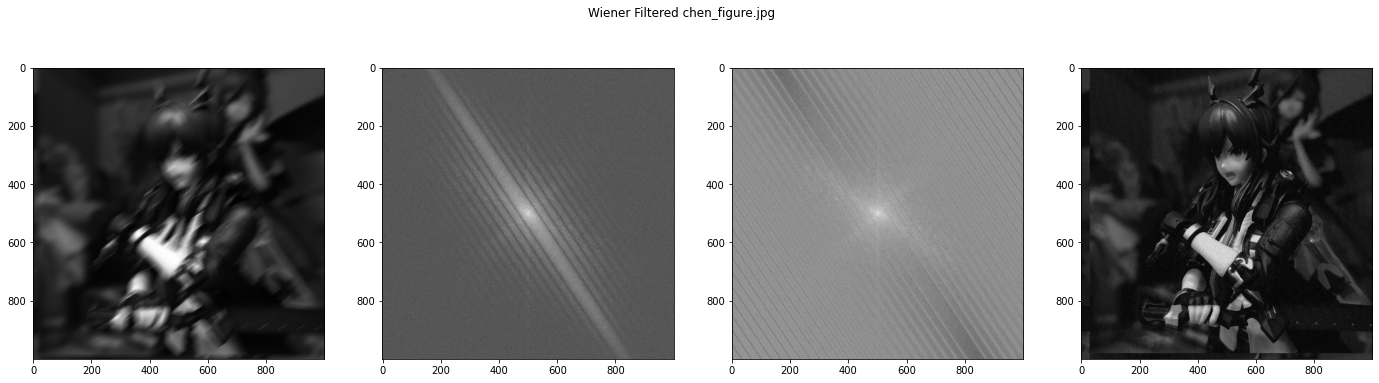

In [10]:
# chen_figure.jpg
(n, m) = (len(chen_figure_filt), len(chen_figure_filt[0]))
shift = 36
(x_shift, y_shift) = (shift * np.cos(np.pi / 180 * 56), -shift * np.sin(np.pi / 180 * 56))
chen_fft, chen_fft_new, chen_new = wiener_filter(chen_figure_filt, 1e-04, x_shift / n, y_shift / m, 1)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
fig.suptitle('Wiener Filtered chen_figure.jpg')
ax1.imshow(chen_figure_filt, cmap='gray')
ax2.imshow(np.log(np.abs(chen_fft)), cmap='gray')
ax3.imshow(np.log(np.abs(chen_fft_new)), cmap='gray')
ax4.imshow(chen_new, cmap='gray')

维纳滤波对我们之前构造的理想退化图像效果很佳，高频细节恢复的比较显著，引入噪声的测试图片也能顺利地恢复得到理想的结果，几乎看不出噪声对结果的影响。

### 约束最小二乘方滤波

我们可以将退化过程列成向量-矩阵形式表达为

$$ \boldsymbol{g} = \boldsymbol{H} \boldsymbol{f} + \boldsymbol{\eta} $$

而在逆滤波中，我们遇到的问题是滤波器矩阵 $\boldsymbol{H}$ 对噪声敏感，而解决这一问题的一种方法是以平滑测度的最优复原为基础，例如图像的二阶差分（拉普拉斯算子）。因此，我们可以将问题变为求解准则函数 $C$ 的最小值，其中

$$ C = \sum_x \sum_y \left[\nabla^2 f(x, y)\right]^2 $$

同时有约束条件

$$ ||\boldsymbol{g} - \boldsymbol{H} \hat{\boldsymbol{f}}||^2 = ||\boldsymbol{\eta}||^2 $$

而这个问题在频域的最优解是

$$ \hat{F}(u, v) = \left[ \frac{H^*(u, v)}{|H(u, v)|^2 + \gamma |P(u, v)|^2} \right] G(u, v) $$

其中 $\gamma$ 是一个需要调整到约束条件的参数，而 $P(u, v)$ 是拉普拉斯核的傅里叶变换，拉普拉斯核需要扩展成和图片等大小。参数 $\gamma$ 可以通过约束条件求解，而此处我们选择手动调参方法实现。

In [11]:
# 约束最小二乘方滤波实现
def least_squares_filter(img, gamma, a, b, T):
    (n, m) = (len(img), len(img[0]))
    img_fft = np.fft.fftshift(np.fft.fft2(img))
    new_img_fft = img_fft.copy()

    laplace = [[0 for _ in range(m)] for _ in range(n)]
    laplace[n // 2][m // 2] = 4
    laplace[n // 2 - 1][m // 2] = laplace[n // 2 + 1][m // 2] = -1
    laplace[n // 2][m // 2 - 1] = laplace[n // 2][m // 2 + 1] = -1
    laplace_fft = np.fft.fftshift(np.fft.fft2(laplace))

    for i in range(n):
        for j in range(m):
            h_val = evaluate_H(T, a, b, i - n // 2, j - m // 2)
            new_img_fft[i][j] *= np.conj(h_val) / (np.abs(h_val)**2 + gamma * np.abs(laplace_fft[i][j])**2)
    new_img = np.abs(np.fft.ifft2(np.fft.ifftshift(new_img_fft)))
    return img_fft, new_img_fft, new_img

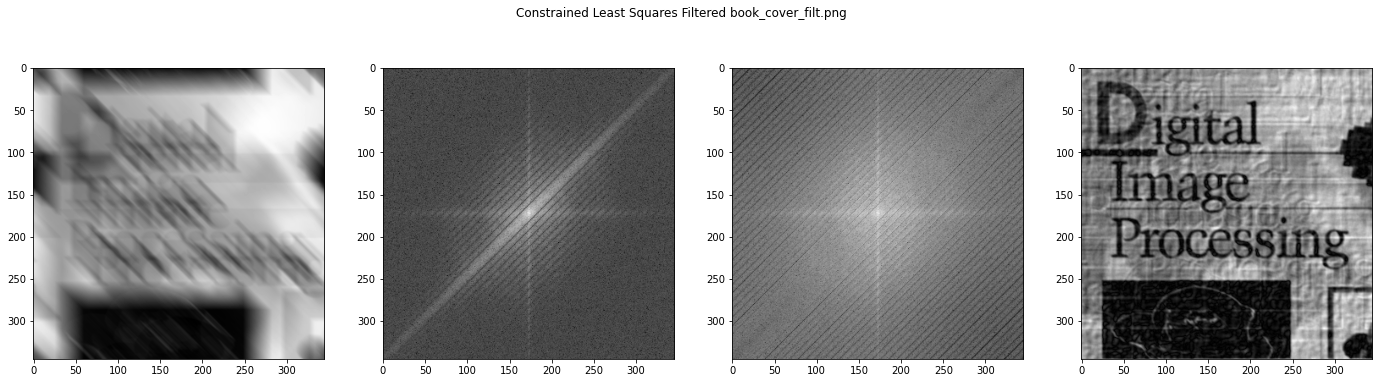

In [12]:
# book_cover_filt.png
(n, m) = (len(book_cover_filt), len(book_cover_filt[0]))
shift = 50
(x_shift, y_shift) = (shift * np.cos(-np.pi / 4), -shift * np.sin(-np.pi / 4))
book_fft, book_fft_new, book_new = least_squares_filter(book_cover_filt, 1e-04, x_shift / n, y_shift / m, 1)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
fig.suptitle('Constrained Least Squares Filtered book_cover_filt.png')
ax1.imshow(book_cover_filt, cmap='gray')
ax2.imshow(np.log(np.abs(book_fft)), cmap='gray')
ax3.imshow(np.log(np.abs(book_fft_new)), cmap='gray')
ax4.imshow(book_new, cmap='gray')

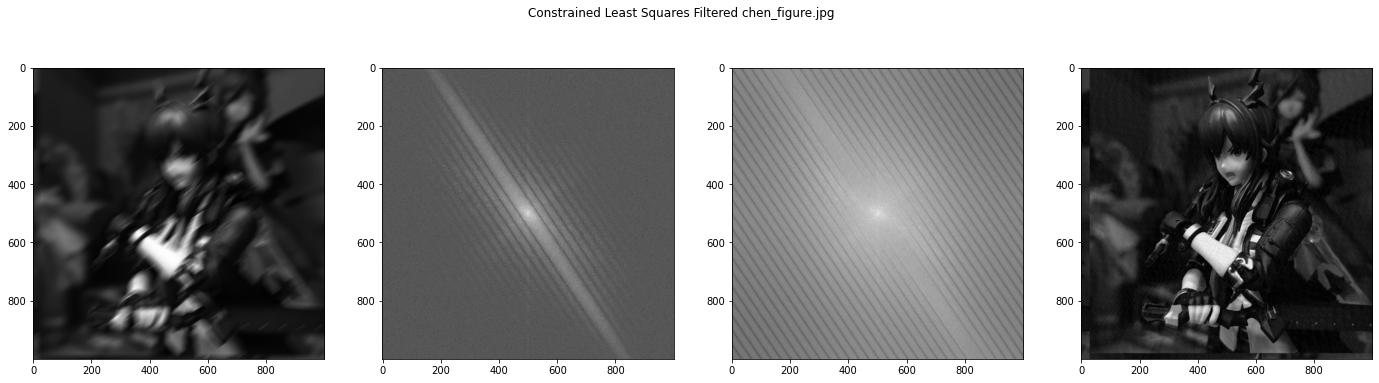

In [13]:
# chen_figure.jpg
(n, m) = (len(chen_figure_filt), len(chen_figure_filt[0]))
shift = 36
(x_shift, y_shift) = (shift * np.cos(np.pi / 180 * 56), -shift * np.sin(np.pi / 180 * 56))
chen_fft, chen_fft_new, chen_new = least_squares_filter(chen_figure_filt, 1e-03, x_shift / n, y_shift / m, 1)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
fig.suptitle('Constrained Least Squares Filtered chen_figure.jpg')
ax1.imshow(chen_figure_filt, cmap='gray')
ax2.imshow(np.log(np.abs(chen_fft)), cmap='gray')
ax3.imshow(np.log(np.abs(chen_fft_new)), cmap='gray')
ax4.imshow(chen_new, cmap='gray')

这种滤波方法同样能应对理想情况与引入噪声的情况，得到相对干净的恢复结果。

## 参考文献

1. 郭红伟, 付波, 田益民, 李娟. 实拍运动模糊图像的退化参数估计与复原 [J]. 激光与红外, 2013, 43 (05): 559-564.
2. Rafael C. Gonzalez, Richard E. Woords. Digital Image Processing [M]. Forth Edition. NJ: Person Education Inc., 2008.